In [1]:
# Imports
from shapely.ops import nearest_points
import geopandas as gpd
import pyproj
from shapely.geometry import Polygon, LineString
from shapely.ops import transform
import matplotlib.pyplot as plt
from pyproj import Geod
import math
import numpy as np
import json
import pandas as pd

In [2]:
# DEFINE USEFUL FUNCTIONS

def get_utm_zone(lon):
    return int((lon + 180) // 6) + 1

def get_utm_proj(lon, lat):
    utm_zone = get_utm_zone(lon)
    is_northern = lat >= 0  # Determine if the zone is in the northern hemisphere
    return f"+proj=utm +zone={utm_zone} +{'north' if is_northern else 'south'} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

# Simplified function to convert a distance in degrees to meters
def degrees_to_meters(distance_in_degrees, utm_proj_rectangle):
    
    # Create transformers for a small unit distance in degrees (1 degree) to meters
    transformer = pyproj.Transformer.from_crs("EPSG:4326", utm_proj_rectangle, always_xy=True)
    
    # Convert 1 degree distance to meters (latitude = 0 because we assume small distance near the UTM zone)
    lon1, lat1 = 0, 0
    lon2, lat2 = 1, 0
    
    x1, y1 = transformer.transform(lon1, lat1)
    x2, y2 = transformer.transform(lon2, lat2)
    
    # Calculate the distance in meters for 1 degree of longitude
    meters_per_degree = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    
    # Convert the input distance in degrees to meters
    distance_in_meters = distance_in_degrees * meters_per_degree
    
    return distance_in_meters

def calculate_area_geodesic(rectangle):
    # Create a Geod object for geodesic calculations
    geod = Geod(ellps="WGS84")

    # Calculate the area using the geod object. The area is returned in square meters.
    area, _ = geod.geometry_area_perimeter(rectangle.geometry)

    return abs(area)

In [42]:
# TILE PROPERTIES 

tile_id = 1
rectangle = gpd.read_file('./data/rectangles.geojson').iloc[int(tile_id)-1]
rectangle_centroid = rectangle.geometry.centroid
utm_proj_rectangle = get_utm_proj(rectangle_centroid.x,rectangle_centroid.y)
rectangle_area = calculate_area_geodesic(rectangle)

OSM_data = gpd.read_file(f"./output_data/OSM_building_footprints_highways_{tile_id-1}.gpkg")#.clip(rectangle['geometry'])
Overture_data = gpd.read_file(f"./output_data/Overture_building_{tile_id}.geojson").to_crs(utm_proj_rectangle)#.clip(rectangle['geometry'])
Overture_data['confidence'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['confidence'])
Overture_data['dataset'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['dataset'])
roads = OSM_data[(OSM_data.building=='nan')].to_crs(utm_proj_rectangle)

# This seems to be a repetitive task; gotta turn it into a function.
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), utm_proj_rectangle, always_xy=True).transform
rectangle_projected = transform(project, rectangle.geometry)
roads_rectangle = roads.clip(rectangle_projected)
buildings_OSM = OSM_data[(OSM_data.building=='yes')].to_crs(utm_proj_rectangle)
road_union = roads.to_crs(utm_proj_rectangle).unary_union # Create a unary union of the road geometries to simplify distance calculation
Overture_data = Overture_data.set_geometry('geometry')[Overture_data.dataset!='OpenStreetMap']
buildings_OSM = buildings_OSM.set_geometry('geometry')
buildings = gpd.GeoDataFrame(pd.concat([buildings_OSM, Overture_data], axis=0, ignore_index=True, join='outer')).drop_duplicates('geometry')

<Axes: >

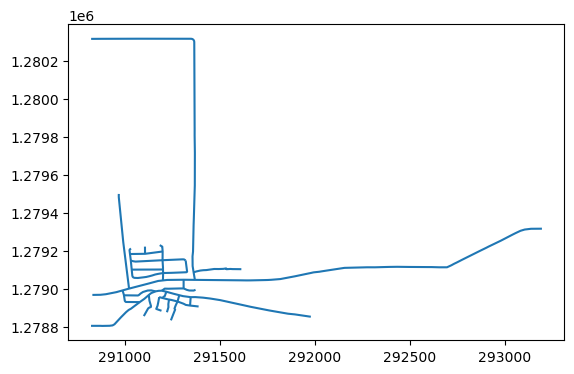

In [49]:
roads.plot()

In [ ]:
# Read needed files: rectangle, buildings, streets


In [ ]:
# Crop shapes outside of rectangles

In [ ]:
# Calculate relevant geometries or values

# Number of buildings


In [5]:
buildings.crs

<Projected CRS: +proj=utm +zone=38 +north +ellps=WGS84 +datum=WGS8 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 38N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Function to calculate the shortest distance to roads
def calculate_minimum_distance_to_roads(building, road_union,utm_proj_rectangle):

    #nearest_geom = nearest_points(crs_transform(building), crs_transform(road_union))[1] #distance to closest road, given the input order
    nearest_geom = nearest_points(building, road_union)[1] #distance to closest road, given the input order
    return building.distance(nearest_geom)#degrees_to_meters(building.distance(nearest_geom), utm_proj_rectangle) 

# Apply the distance calculation to each building
buildings.loc[:,'distance_to_road'] = buildings['geometry'].apply(lambda x: x.centroid).apply(calculate_minimum_distance_to_roads, road_union=road_union, utm_proj_rectangle=utm_proj_rectangle)


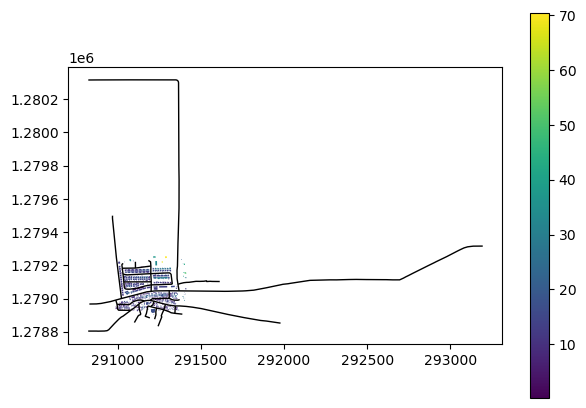

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
buildings.plot(column='distance_to_road', ax=ax, legend=True, cmap='viridis')
#roads_clipped = roads.clip(rectangle['geometry'])
roads.plot(ax=ax, color='black', linewidth=1)
plt.show()


In [8]:
buildings['distance_to_road'].describe()

count    556.000000
mean      12.749244
std        7.697521
min        0.170147
25%        7.703754
50%       11.952628
75%       15.679781
max       70.424361
Name: distance_to_road, dtype: float64

In [ ]:
# Intersections

In [ ]:

# Block polygons

In [ ]:

# City block width

In [9]:
# Calculate measures
buildings['distance_to_road'].describe()

count    556.000000
mean      12.749244
std        7.697521
min        0.170147
25%        7.703754
50%       11.952628
75%       15.679781
max       70.424361
Name: distance_to_road, dtype: float64

In [10]:
#1 Share of building footprints that are less than 10-meters away from the nearest road

def metric_1_distance_less_than_10m(buildings):
    return 100.*((sum(buildings['distance_to_road']<=10))/len(buildings))

metric_1_distance_less_than_10m(buildings)

40.647482014388494

In [11]:
#2 Average distance of building footprint centroids to roads
def metric_2_average_distance_to_roads(buildings):
    return buildings['distance_to_road'].mean()

metric_2_average_distance_to_roads(buildings)


12.749243981281474

In [46]:
#3 Density of roads
# THIS WORKS ONLY IF I CAN ENSURE ALL AREAS ARE THE SAME FOR ALL TILES. I CAN ALSO CALCULATE AREA FROM THE CREATION OF THE RECTANGLES.
def metric_3_road_density(roads_rectangle,rectangle_area):
    #meter_length = degrees_to_meters(road_union.length,utm_zone_rectangle=utm_zone_rectangle)
    km_length = roads_rectangle.length.sum()/1000.
    rectangle_area_km2 = rectangle_area/1000000.
    return km_length/rectangle_area_km2

metric_3_road_density(roads_rectangle,rectangle_area)

23.161148741520798

In [48]:
roads

,element_type,osmid,highway,nodes,lanes,surface,building,ways,type,geometry
0,way,101529381,tertiary,"[5306138425, 3789229469, 410875645, 3789229468...",2,asphalt,nan,nan,nan,"LINESTRING (293195.832 1279315.884, 293138.557..."
1,way,169300472,unclassified,"[1804665870, 5801139055, 5798878089, 579894548...",nan,nan,nan,nan,nan,"LINESTRING (291978.855 1278852.167, 291922.291..."
2,way,612973787,residential,"[5796505954, 5797561093, 5797542356, 706019065...",nan,nan,nan,nan,nan,"LINESTRING (290821.860 1280315.454, 290873.112..."
3,way,613013714,residential,"[3738998712, 5801431542, 5801431541, 580143154...",nan,nan,nan,nan,nan,"LINESTRING (291099.341 1278855.705, 291121.952..."
4,way,613013715,residential,"[5801431550, 5801487603, 5801431549, 580143154...",nan,nan,nan,nan,nan,"LINESTRING (291241.939 1278833.286, 291254.339..."
5,way,613017866,residential,"[1804671825, 5801455389]",nan,nan,nan,nan,nan,"LINESTRING (291346.056 1278955.362, 291342.923..."
6,way,613017867,residential,"[5801431545, 5801455392, 5801455390, 580145538...",nan,nan,nan,nan,nan,"LINESTRING (291276.913 1278932.492, 291309.146..."
7,way,613017868,residential,"[5801213281, 5801455398, 5801455397, 580145539...",nan,nan,nan,nan,nan,"LINESTRING (291077.830 1278929.312, 291004.841..."
8,way,613017869,residential,"[5801213278, 5801455407, 5801455406, 580145540...",nan,nan,nan,nan,nan,"LINESTRING (291160.956 1278985.811, 291138.714..."
9,way,613017870,residential,"[5801213277, 5801455416, 5801455414, 580145541...",nan,nan,nan,nan,nan,"LINESTRING (291194.482 1278989.359, 291209.325..."


In [30]:
type(rectangle.geometry)

shapely.geometry.polygon.Polygon

<Axes: >

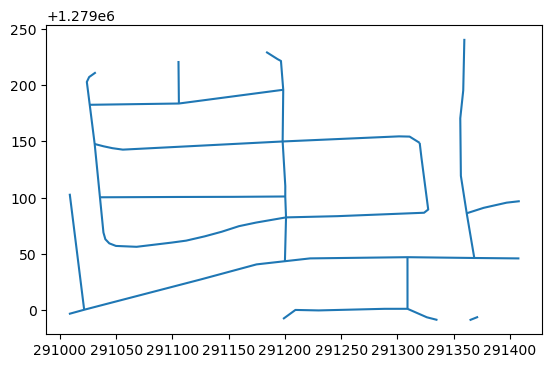

In [ ]:
#9 Tortuosity index


In [ ]:
#4 Share of 3-way and 4-way intersections 

In [ ]:
#5 Number of 4-way intersections


In [ ]:
buildings['geometry'].iloc[7].exterior.coords[0]

In [ ]:
#6 Average building footprint orientation of the tile

def longest_segment(polygon):
    # Ensure the input is a valid Polygon
    if not isinstance(polygon, Polygon):
        raise TypeError("The input must be a shapely Polygon object.")
    
    # Get the exterior coordinates of the polygon
    exterior_coords = polygon.exterior.coords
    
    # Initialize variables to track the longest segment
    max_length = 0
    longest_segment = None
    
    # Iterate through the exterior coordinates to find the longest segment
    for i in range(len(exterior_coords) - 1):
        # Create a line segment from consecutive coordinates
        segment = LineString([exterior_coords[i], exterior_coords[i+1]])
        
        # Calculate the length of the segment
        segment_length = segment.length
        
        # Update the longest segment if this one is longer
        if segment_length > max_length:
            max_length = segment_length
            longest_segment = segment
    
    return longest_segment

#longest_seg = longest_segment(polygon)



def calculate_azimuth(segment):
    # Extract start and end points of the segment
    start_point = segment.coords[0]
    end_point = segment.coords[1]
    
    # Calculate the difference in coordinates
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]
    
    # Calculate the azimuth in radians
    azimuth_rad = math.atan2(delta_x, delta_y)
    
    # Convert the azimuth to degrees
    azimuth_deg = math.degrees(azimuth_rad)
    
    # Normalize the azimuth to be within 0 to 360 degrees
    #if azimuth_deg < 0:
    #    azimuth_deg += 360
    
    return np.abs(azimuth_deg)

# Assuming you have the longest segment from the previous example
#azimuth = calculate_azimuth(longest_seg)

buildings.loc[:,'azimuth'] = buildings['geometry'].apply(lambda x: calculate_azimuth(longest_segment(x)))

def metric_6_deviation_of_building_azimuth(buildings):
    return buildings.azimuth.std()/180.

metric_6_deviation_of_building_azimuth(buildings)

In [ ]:
#10 Average angle between road segments
buildings.plot()

In [ ]:
#7 Average block width


In [ ]:
#8 Share of footprints intersected by equidistant line or equivalent segment